# Yaginuma 2025 Thermal Paper Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
import datetime as dt

In [2]:
# Constants
mu = 1.32712440018e20 # m^3/s^2
AU = 1.496e11 # m
q_AU = 1.357 # AU perihelion
e = 6.1437 # eccentricity
F0 = 1367.0 # W/m^2 solar constant at 1 AU
albedo = 0.2 # albedo
eps = 0.95 # emissivity
sigSB = 5.670374e-8 # W/m^2/K^4 Stefan–Boltzmann
f = 1/np.pi # rtation factor
kappa = 0.001 # W/m/K thermal conductivity
rho = 1000.0 # kg/m^3 density
Cp = 550.0 # J/kg/K heat capacoty
alpha = kappa / (rho * Cp) # m^2/s thermal diffusivity

# Simulation depth grid for 1D diffusion
z_max = 10.0 # m
dz = 0.005 # m steps
z = np.arange(0, z_max + dz, dz)
nz = z.size

# Time
total_days = 13000
dt_sec = 50.0
steps = int(total_days * 86400 / dt_sec)
record_step = int(86400 / dt_sec)  # save once per day

# Hyperbolic orbit
def hyperbolic_a(mu, q_AU, e, AU):
    q = q_AU * AU
    a = -q / (e - 1.0)
    n = np.sqrt(mu / abs(a)**3)
    return a, n

a = -(q_AU * AU) / (e - 1.0) # semi-major axis, negative for hyperbola
n = np.sqrt(mu / abs(a)**3) # hyperbolic mean motion (1/s)

def solve_hyperbolic_kepler(M, e, iters=50):
    # Solve e*sinh(H) - H = M
    H = np.log(2 * abs(M) / e + 1.8)
    H = H if M >= 0 else -H
    for _ in range(iters):
        F = e*np.sinh(H) - H - M
        dF = e*np.cosh(H) - 1.0
        H -= F / dF
    return H

def r_of_day(day):
    # heliocentric distance r in AU, where day=0 is perihelion
    H = solve_hyperbolic_kepler(n * day * 86400.0, e)
    return abs(a) * (e*np.cosh(H) - 1.0) / AU

t_days = np.arange(-6500, 6500)
r_record = np.array([r_of_day(d) for d in t_days])

def day_for_r(R_au, side='out'):
    # Find the time when the object reaches distance R_au
    if R_au < q_AU:
        raise ValueError("R < perihelion distance")
    if side == 'out':
        mask = t_days >= 0
    elif side == 'in':
        mask = t_days <= 0
    else:
        raise ValueError("side must be 'in' or 'out'")

    t = t_days[mask]
    r = r_record[mask]
    # make sure r is increasing for interpolation
    if r[0] > r[-1]:
        r = r[::-1]
        t = t[::-1]
    return float(np.interp(R_au, r, t))

# Surface boundary condition
def surface_temp_newton(T_guess, T1, S, kappa, dz, eps, sigSB, iters=5):
    # Solve the surface temperature using Newton's method
    T0 = T_guess
    for _ in range(iters):
        F = kappa*(T1 - T0)/dz - eps*sigSB*T0**4 + S
        dF = -kappa/dz - 4*eps*sigSB*T0**3
        T0 -= F / dF
    return T0

def run_model():
    coef = alpha * dt_sec / dz**2  # diffusion coefficient for time stepping

    # initial temperature (equilibrium at 100 AU)
    T_inf = ((f*F0*(1-albedo)) / (4*eps*sigSB*100.0**2))**0.25
    T = np.full(nz, T_inf)

    # heliocentric distance as a function of time
    r_series = np.interp((np.arange(steps) * dt_sec) / 86400.0 - 6500.0,t_days, r_record)

    saved = []
    next_record = 0  # next time step to save
    for i in range(steps):
        # temperature diffusion
        Tn = T.copy()
        Tn[1:-1] = T[1:-1] + coef * (T[2:] - 2*T[1:-1] + T[:-2])

        # bottom boundary: no heat flux
        Tn[-1] = Tn[-2]
        # surface boundary: balance of sunlight and radiation
        S = f * F0 * (1 - albedo) / (r_series[i]**2)
        Tn[0] = surface_temp_newton(T[0], Tn[1], S, kappa, dz, eps, sigSB)
        T = Tn
        # save once per day
        if i == next_record:
            saved.append(T.copy())
            next_record += record_step

    # stack saved profiles into array
    T_record = np.column_stack(saved)
    t_plot = t_days[:T_record.shape[1]]
    return t_plot, T_record

t_plot, T_plot = run_model()

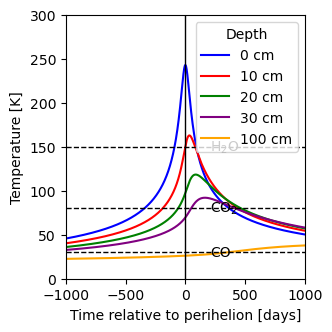

In [3]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(8.7*cm, 8.7*cm))

depths_cm = [0, 10, 20, 30, 100]
idxs = []
for d_cm in depths_cm:
    d_m = d_cm * 0.01
    idxs.append(int(d_m / dz))

colors = ['blue', 'red', 'green', 'purple', 'orange']
labels = ['0 cm', '10 cm', '20 cm', '30 cm', '100 cm']
for idx, c, lab in zip(idxs, colors, labels):
    ax.plot(t_plot, T_plot[idx], color=c, label=lab, lw=1.5)

ax.axvline(0, color='k', lw=1)
for spec, Tsub in zip(('H$_2$O', 'CO$_2$', 'CO'), (150, 80, 30)):
    ax.axhline(Tsub, ls='--', lw=1, color='k')
    ax.text(205, Tsub, spec, va='center', ha='left')

ax.set_xlim(-1000, 1000)
ax.set_ylim(0, 300)
ax.set_xlabel("Time relative to perihelion [days]")
ax.set_ylabel("Temperature [K]")
ax.legend(title="Depth", loc='upper right')
plt.tight_layout()
plt.show()

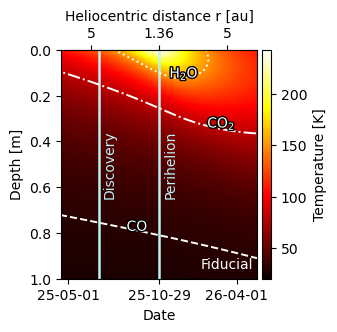

In [4]:
perihelion_utc = dt.datetime(2025, 10, 29)
discovery_utc  = dt.datetime(2025, 7, 1)
x_disc = (discovery_utc - perihelion_utc).days  # negative = before perihelion

fig, ax = plt.subplots(figsize=(8.7*cm, 8.7*cm))
pcm = ax.pcolormesh(t_plot, z, T_plot, cmap="hot", shading="auto")

# chose to show -7 to 7 au region
d_in  = day_for_r(7.0, side="in")
d_out = day_for_r(7.0, side="out")
ax.set_xlim(d_in, d_out)

# labels
for x, label in [(x_disc, "Discovery"), (0.0, "Perihelion")]:
    ax.axvline(x, color="#BAF3F5", lw=1.8)
    ax.text(x + 8, 0.5, label, rotation=90, color="#BAF3F5", ha="left", va="center", clip_on=True)
    
ax.text(0.98, 0.03, "Fiducial", transform=ax.transAxes, ha="right", va="bottom", color="white", fontsize=10)

# sublimation temperature lines
species    = ["CO", "CO$_2$", "H$_2$O"]
temps      = [30, 80, 150]
linestyles = ["--", "-.", ":"]

ax.contour(t_plot, z, T_plot, levels=temps, colors="white", linewidths=1.4, linestyles=linestyles)

def isotherm_depth(Trec, z, Tsub):
    # Find how deep the temperature reaches Tsub
    depth = np.full(Trec.shape[1], np.nan)  # output array
    prev = None # this is previous depth

    for j in range(Trec.shape[1]): # loop over time
        Tcol = Trec[:, j]     # temperature vs depth at this time

        # find where temperature crosses Tsub
        sign = np.sign(Tcol - Tsub)
        idx = np.where(np.diff(sign) != 0)[0]

        if idx.size == 0:
            continue    # no crossing

        # linear interpolation to get depth
        z0, z1 = z[idx], z[idx + 1]
        T0, T1 = Tcol[idx], Tcol[idx + 1]
        z_cross = z0 + (Tsub - T0) * (z1 - z0) / (T1 - T0)

        # choose closest crossing to previous step
        depth[j] = z_cross[0] if prev is None else z_cross[np.argmin(np.abs(z_cross - prev))]
        prev = depth[j]

    return depth

# place labels
label_x = [-80, 80, 5]
for spec, Tsub, x_lab in zip(species, temps, label_x):
    dsub = isotherm_depth(T_plot, z, Tsub)
    ok = np.where(np.isfinite(dsub))[0]
    if ok.size == 0:
        continue

    # choose the time index closest to x_lab
    j0 = ok[np.argmin(np.abs(t_plot[ok] - x_lab))]

    ax.text(t_plot[j0] + 15, dsub[j0], spec, color="white", fontsize=10, ha="left", va="center", path_effects=[pe.Stroke(linewidth=2, foreground="black"), pe.Normal()])

# days on the bottom x-axis
def days_from_peri(date_utc):
    return (date_utc - perihelion_utc).days

month_ticks = [days_from_peri(dt.datetime(2025, 5, 1)), days_from_peri(dt.datetime(2025, 10, 29)),days_from_peri(dt.datetime(2026, 4, 1)),]

ax.xaxis.set_major_locator(mticker.FixedLocator(month_ticks))
ax.set_xticklabels(["25-05-01", "25-10-29", "26-04-01"], fontsize=10)
ax.set_xlabel("Date", fontsize=10)

# give the bottom labels some space
fig.subplots_adjust(bottom=0.22)

#heliocentric distnce on top x-axis
target_distances = [5, 10, 20, 30]
tick_days, tick_labels = [], []

for R in target_distances:
    for side in ("in", "out"):
        tR = day_for_r(R, side=side)
        if d_in <= tR <= d_out:
            tick_days.append(tR)
            tick_labels.append(f"{R:g}")

# always include perihelion point
tick_days.append(0.0)
tick_labels.append(f"{q_AU:.2f}")
order = np.argsort(tick_days)
tick_days = list(np.array(tick_days)[order])
tick_labels = list(np.array(tick_labels)[order])

ax_top = ax.secondary_xaxis("top")
ax_top.xaxis.set_major_locator(mticker.FixedLocator(tick_days))
ax_top.set_xticklabels(tick_labels)
ax_top.set_xlabel("Heliocentric distance r [au]", fontsize=10)
ax.set_ylim(0, 1.0)
ax.invert_yaxis()
ax.set_ylabel("Depth [m]", fontsize=10)
cbar = plt.colorbar(pcm, ax=ax, pad=0.02, aspect=25)
cbar.set_label("Temperature [K]", fontsize=10)
plt.tight_layout()
plt.show()